In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statsmodels.stats.multitest as smm
import numpy as np
# from sklearn.gaussian_process import GaussianProcess
from scipy.signal import savgol_filter    
import warnings
import scipy.stats as scs

warnings.simplefilter(action='ignore', category=FutureWarning)

In [49]:
data = pd.read_csv('~/github/Functional_analysis/outputs/Effect_sizes_random_gene_sets_wo_ASD_1_3.tsv', sep = '\t')

In [50]:
# Extract the number of random genes from the list name
data['size'] = data['gene_list_name'].str.extract('(.*)_\\d*$')
data['size'] = data['size'].astype(int)

# data = data[(data['size'] >50) & (data['size'] <=100)]

data['pvalue_adj'] = smm.fdrcorrection(data['pvalue'])[1]
print(data.head())
es_data = data.pivot(columns='TYPE', values=['Estimate', 'pvalue_adj', 'n_unique_genes'], index='gene_list_name')
tmp_shape = es_data.shape[0]

es_data['gene_list_name'] = es_data.index
es_data['size'] = es_data['gene_list_name'].str.extract('(.*)_\\d*$')
es_data['size'] = es_data['size'].astype(int)
es_data.sort_values('size', inplace=True)
# es_data = es_data[((es_data.pvalue_adj.DEL <0.05) & (es_data.pvalue_adj.DEL >0)) | ((es_data.pvalue_adj.DUP <0.05)& (es_data.pvalue_adj.DUP >0))]
print(es_data.shape[0]/tmp_shape)
es_data.columns = ['Estimate_DEL','Estimate_DUP', 'pvalue_DEL', 'pvalue_DUP', 'n_DEL_genes', 'n_DUP_genes', 'gene_list_name', 'size']
print(scs.spearmanr(es_data.Estimate_DEL, es_data.Estimate_DUP))
print(es_data.head())

   Estimate    pvalue TYPE  n_carriers  n_unique_genes gene_list_name  size  \
0 -0.031529  0.918519  DEL          10               4           10_0    10   
1 -0.339141  0.228596  DUP          12               9           10_0    10   
2  0.429435  0.445077  DEL           3               1           10_1    10   
3 -0.000356  0.998870  DUP          15               6           10_1    10   
4  0.013079  0.964524  DEL          11               4           10_2    10   

   pvalue_adj  
0    0.953275  
1    0.382948  
2    0.605337  
3    0.999361  
4    0.980081  
1.0
SignificanceResult(statistic=-0.19925427784015184, pvalue=0.0)
                Estimate_DEL  Estimate_DUP  pvalue_DEL  pvalue_DUP  \
gene_list_name                                                       
10_74               0.099845      0.242403    0.804850    0.365926   
10_76              -0.133556     -0.097592    0.836668    0.712646   
10_75              -0.128399     -0.247828    0.843384    0.292607   
10_73       

In [51]:
def moving_average_with_edge_handling(data, window_size):
    """
    Apply a moving average to a 1D array while handling edge effects.

    Args:
        data (numpy.ndarray): The input 1D array of data.
        window_size (int): The size of the moving average window.

    Returns:
        numpy.ndarray: The smoothed data with edge effects handled.
    """
    # Ensure window_size is an odd number
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd number")

    half_window = window_size // 2

    # Pad the data at the edges to handle boundary effects
    padded_data = np.pad(data, (half_window, half_window), mode='edge')

    # Apply the moving average
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data


size          int64
mean_r      float64
sd_r        float64
mu_s        float64
sd_s        float64
sd_clean    float64
dtype: object


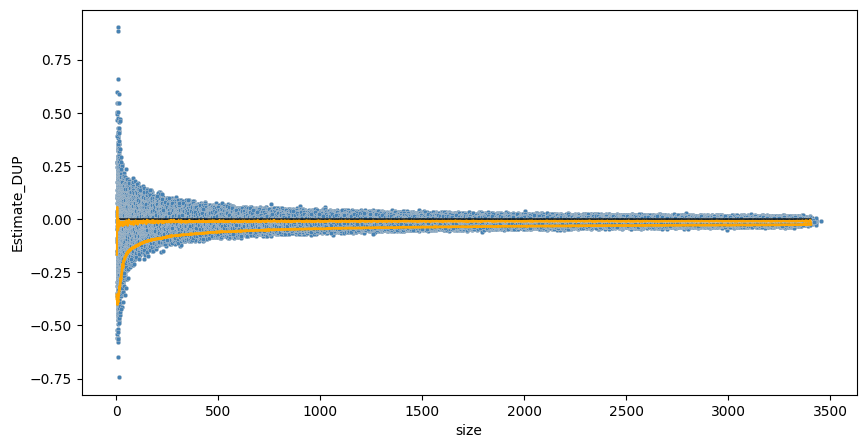

In [47]:
fig, ax = plt.subplots(1,figsize=(10,5))
es_data.dropna(inplace=True)
es_data['n_DUP_genes'] = es_data['n_DUP_genes'].astype(int)
describe_df = pd.DataFrame()
for size in es_data['n_DUP_genes'].unique():
    tmp_data = es_data[es_data['n_DUP_genes'] == size]
    describe_df = pd.concat([describe_df, pd.DataFrame({'size':[size], 'mean_r':[tmp_data.Estimate_DUP.mean()], 'sd_r':[tmp_data.Estimate_DUP.std()]})])

window_size = 41
describe_df['mu_s'] = moving_average_with_edge_handling(describe_df['mean_r'], window_size)
describe_df['sd_s'] = moving_average_with_edge_handling(describe_df['sd_r'], window_size)
describe_df['sd_clean'] = describe_df.mu_s - describe_df.sd_s*2
# print(es_go.n_DUP.max())
# print(describe_df.head())
es_data['size']= es_data.n_DUP_genes
sns.scatterplot(data =es_data, x='size', y='Estimate_DUP', s=10, c='steelblue', edgecolor='lightgrey')

print(describe_df.dtypes)
describe_df.to_csv('Random_DUP_unique_distribution_mu_sd.tsv', sep='\t', index=False) 
describe_df = describe_df.dropna(subset=['size', 'sd_clean'])

describe_df = describe_df.sort_values(by='size')


sns.lineplot(data=describe_df, x='size', y='sd_clean', ax = ax, lw=2, c='orange')
sns.lineplot(data=describe_df, x='size', y='mu_s', ax = ax, lw=2, c='lightgray')
sns.lineplot(data=describe_df, x='size', y=0, ax = ax, lw=1, c='black')
sns.lineplot(data=describe_df, x='size', y='mean_r', ax = ax, c='orange')

# sns.lineplot(data=describe_df, x='size', y='sd1', ax = ax, lw=4, c='lightcoral')

# # sns.lineplot(data=describe_df, x='size', y=tmp1, ax = ax, lw=3)
# # sns.lineplot(data=describe_df, x='size', y='sd2', c='orange', ax = ax)
# sns.lineplot(data=describe_df, x='size', y='sd2', ax = ax, lw=4, c='lightblue')
# sns.lineplot(data=describe_df, x='size', y='sd12', ax = ax, lw=3, c='firebrick')
# sns.lineplot(data=describe_df, x='size', y='sd22', ax = ax, lw=3, c='navy')


# ax.set_xscale('log')
# ax.set_xlim(10,580)
# ax.set_ylim(-0.1, 0.1)
plt.show()

   size    mean_r      sd_r      mu_s      sd_s       sd1
0    10 -0.025576  0.458467 -0.011764  0.371045  0.730327
0    11 -0.050844  0.470474 -0.011285  0.365313  0.719340
0    12  0.048145  0.358317 -0.010635  0.358599  0.706563
0    13  0.020669  0.376885 -0.009319  0.352100  0.694880
0    14 -0.003518  0.361753 -0.009521  0.345997  0.682473


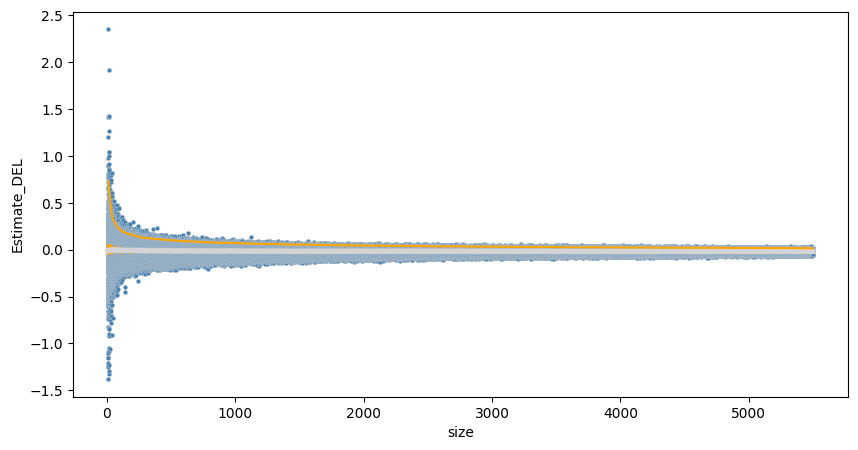

In [52]:
fig, ax = plt.subplots(1,figsize=(10,5))
es_data.dropna(inplace=True)

describe_df = pd.DataFrame()
for size in es_data['size'].unique():
    tmp_data = es_data[es_data['size'] == size]
    describe_df = pd.concat([describe_df, pd.DataFrame({'size':[size], 'mean_r':[tmp_data.Estimate_DEL.mean()], 'sd_r':[tmp_data.Estimate_DEL.std()]})])

window_size = 41
describe_df['mu_s'] = moving_average_with_edge_handling(describe_df['mean_r'], window_size)
describe_df['sd_s'] = moving_average_with_edge_handling(describe_df['sd_r'], window_size)
describe_df['sd1'] = describe_df.mu_s + describe_df.sd_s*2
# print(es_go.n_DUP.max())
# print(describe_df.head())
sns.scatterplot(data =es_data, x='size', y='Estimate_DEL', s=10, c='steelblue', edgecolor='lightgrey')
print(describe_df.head())
describe_df.to_csv('Random_DEL_distribution_mu_sd.tsv', sep='\t', index=False) 

sns.lineplot(data=describe_df, x='size', y=0, ax = ax, lw=1, c='black')
sns.lineplot(data=describe_df, x='size', y='mean_r', ax = ax, c='orange')
sns.lineplot(data=describe_df, x='size', y='mu_s', ax = ax, lw=4, c='lightgray')
sns.lineplot(data=describe_df, x='size', y='sd1', c='orange', ax = ax)
# sns.lineplot(data=describe_df, x='size', y='sd1', ax = ax, lw=4, c='lightcoral')

# # sns.lineplot(data=describe_df, x='size', y=tmp1, ax = ax, lw=3)
# # sns.lineplot(data=describe_df, x='size', y='sd2', c='orange', ax = ax)
# sns.lineplot(data=describe_df, x='size', y='sd2', ax = ax, lw=4, c='lightblue')
# sns.lineplot(data=describe_df, x='size', y='sd12', ax = ax, lw=3, c='firebrick')
# sns.lineplot(data=describe_df, x='size', y='sd22', ax = ax, lw=3, c='navy')


# ax.set_xscale('log')
# ax.set_xlim(0,580)
# ax.set_ylim(-0.1, 0.1)
plt.show()

In [4]:
ratio = 0.426609501927956

def compute_tagDS(es_data, DEL_name, DUP_name, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row[DEL_name] + b*row[DUP_name] + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row[DEL_name] - row[DUP_name]
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    return tagDS_vals  

In [5]:
es_data['tagDS'] = compute_tagDS(es_data, 'Estimate_DEL', 'Estimate_DUP', ratio)

In [6]:
describe_df = pd.DataFrame()
for size in es_data['size'].unique():
    tmp_data = es_data[es_data['size'] == size]
    describe_df = pd.concat([describe_df, pd.DataFrame({'size':[size], 'mean_r':[tmp_data.tagDS.mean()], 'sd_r':[tmp_data.tagDS.std()]})])

# noisy_data = # Your noisy data here
window_size = 41
describe_df['mu_s'] = moving_average_with_edge_handling(describe_df['mean_r'], window_size)
describe_df['sd_s'] = moving_average_with_edge_handling(describe_df['sd_r'], window_size)

describe_df.to_csv('Random_tagDS_distribution_mu_sd.tsv', sep='\t', index=False) 
describe_df['sd1'] = describe_df.mu_s + describe_df.sd_s
describe_df['sd12'] = describe_df.mu_s + describe_df.sd_s *2

describe_df['sd2'] = describe_df.mu_s - describe_df.sd_s
describe_df['sd22'] = describe_df.mu_s - describe_df.sd_s*2


In [13]:
data_go = pd.read_csv('/home/rennetho/github/Functional_analysis/outputs/Effect_sizes_GO_terms_sensitivity.tsv', sep='\t')
data_go['coverage'] = data_go.gene_list_n / data_go.n_unique_genes
data_go_clean = data_go[(data_go.cat == 'g') &
                        (data_go.ancestry == 'All') &
                         (data_go.diagnosis == 'wo_ASD') &
                        (data_go.gene_list_n >= 10) &
                        (data_go.gene_list_n < 500) &
                        (data_go.max_score == 10000) &
                        (data_go.total_carriers >= 30) & 
                        (data_go.model_type == '1_3') & 
                       (data_go.coverage >= 0.20) 
                           ]

data_all =  data_go_clean

In [7]:
data_sw = pd.read_csv('/home/rennetho/github/Functional_analysis/outputs/Effect_sizes_Sliding_window.tsv', sep='\t')
data_sw_clean = data_sw[(data_sw.cat == 'g') &
                        (data_sw.ancestry == 'All') &
                        (data_sw.diagnosis == 'wo_ASD') &
                        (data_sw.gene_list_name != 'ddd_genes') &
                          (data_sw.model_type == '1_3') 
                           ]
print(data_sw_clean.shape)
data_all =  data_sw_clean

(76, 22)


In [7]:
data_hpa = pd.read_csv('/home/rennetho/github/Functional_analysis/outputs/Effect_sizes_HPA_brain.tsv', sep='\t')
data_hpa_clean = data_hpa[(data_hpa.cat == 'g') &
                        (data_hpa.ancestry == 'All') &
                        (data_hpa.diagnosis == 'wo_ASD') &
                          (data_hpa.model_type == '1_3') 
                           ]
print(data_hpa_clean.shape)
data_all =  data_hpa_clean

(430, 22)


In [8]:
data_hpa = pd.read_csv('/home/rennetho/github/Functional_analysis/outputs/Effect_sizes_GTEx_tissue.tsv', sep='\t')
data_hpa_clean = data_hpa[(data_hpa.cat == 'g') &
                        (data_hpa.ancestry == 'All') &
                        (data_hpa.diagnosis == 'wo_ASD') &
                          (data_hpa.model_type == '1_3') 
                           ]
print(data_hpa_clean.shape)
data_all =  data_hpa_clean

FileNotFoundError: [Errno 2] No such file or directory: '/home/rennetho/github/Functional_analysis/outputs/Effect_sizes_GTEx_tissue.tsv'

In [27]:
# data_all =  data_hpa_clean
# data_all =  data_sw_clean
data_all =  data_go_clean

In [8]:
new_data = pd.DataFrame()
for cnv_type in data_all.TYPE.unique():
    for combo in set(zip(data_all['model_type'], data_all['win'],  data_all['diagnosis'])):
        print(combo)
        tmp = data_all[(data_all.TYPE==cnv_type) & (data_all.model_type==combo[0]) & (data_all.win==combo[1]) & (data_all.diagnosis==combo[2])].copy()
        tmp['pvalue_adj'] = smm.fdrcorrection(tmp['pvalue'])[1]
        new_data = pd.concat([new_data, tmp])
        
# new_data = new_data[new_data.pvalue_adj < 0.05]
print(new_data.gene_list_name.nunique())

es_go = new_data.pivot(columns='TYPE', values=['Estimate','gene_list_n', 'pvalue_adj'], index='gene_list_name')
es_go = pd.DataFrame(es_go.to_records())
es_go.columns = ['gene_list_name', 'Estimate_DEL', 'Estimate_DUP', 'n_DEL', 'n_DUP', 'pvalue_DEL', 'pvalue_DUP']
es_go = es_go[(es_go.pvalue_DEL < 0.05)|(es_go.pvalue_DUP < 0.05)]

es_go['tagDS'] = compute_tagDS(pd.DataFrame(es_go.to_records()), 'Estimate_DEL', 'Estimate_DUP', ratio)
print(es_go.head())

('1_3', 1, 'wo_ASD')
('1_3', 1, 'wo_ASD')
215
                          gene_list_name  Estimate_DEL  Estimate_DUP   n_DEL  \
0                Brain/amygdala/amygdala     -0.102586      0.009679   684.0   
1          Brain/amygdala/basal amygdala     -0.009037     -0.036092  1424.0   
2        Brain/amygdala/central amygdala      0.024911     -0.034806   943.0   
3  Brain/amygdala/corticomedial amygdala     -0.001361     -0.022645  1560.0   
4        Brain/amygdala/lateral amygdala      0.001854     -0.028077  1251.0   

    n_DUP  pvalue_DEL  pvalue_DUP     tagDS  
0   684.0    0.000182    0.644978  0.049156  
1  1424.0    0.688817    0.000713 -0.029651  
2   943.0    0.382119    0.010977 -0.041789  
3  1560.0    0.941843    0.039897 -0.020295  
4  1251.0    0.925103    0.002050 -0.026553  


   size    mean_r      sd_r      mu_s      sd_s       sd1      sd12       sd2  \
0    50 -0.017309  0.109259 -0.016777  0.106473  0.089697  0.196170 -0.123250   
0    51 -0.007092  0.115562 -0.016543  0.106308  0.089764  0.196072 -0.122851   
0    52 -0.028091  0.138353 -0.016653  0.106033  0.089380  0.195413 -0.122686   
0    53 -0.029705  0.104533 -0.016838  0.105548  0.088710  0.194258 -0.122386   
0    54 -0.000145  0.107681 -0.017058  0.105338  0.088280  0.193618 -0.122396   

       sd22  
0 -0.229723  
0 -0.229159  
0 -0.228719  
0 -0.227934  
0 -0.227734  


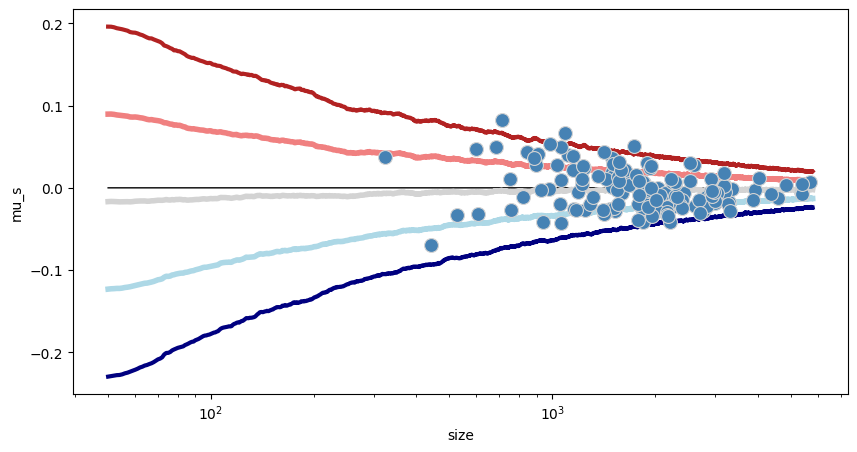

In [9]:

fig, ax = plt.subplots(1,figsize=(10,5))
es_data.dropna(inplace=True)
es_go.dropna(inplace=True)
# print(es_go.n_DUP.max())
print(describe_df.head())


sns.lineplot(data=describe_df, x='size', y=0, ax = ax, lw=1, c='black')
# sns.lineplot(data=describe_df, x='size', y='mean_r', ax = ax, c='orange')
sns.lineplot(data=describe_df, x='size', y='mu_s', ax = ax, lw=4, c='lightgray')
# sns.lineplot(data=describe_df, x='size', y='sd1', c='orange', ax = ax)
sns.lineplot(data=describe_df, x='size', y='sd1', ax = ax, lw=4, c='lightcoral')

# sns.lineplot(data=describe_df, x='size', y=tmp1, ax = ax, lw=3)
# sns.lineplot(data=describe_df, x='size', y='sd2', c='orange', ax = ax)
sns.lineplot(data=describe_df, x='size', y='sd2', ax = ax, lw=4, c='lightblue')
sns.lineplot(data=describe_df, x='size', y='sd12', ax = ax, lw=3, c='firebrick')
sns.lineplot(data=describe_df, x='size', y='sd22', ax = ax, lw=3, c='navy')


sns.scatterplot(data =es_go, x='n_DUP', y='tagDS', s=100, c='steelblue', zorder=10, edgecolor='lightgrey')
ax.set_xscale('log')
# ax.set_xlim(0,580)
# ax.set_ylim(-0.1, 0.1)
plt.savefig('tagDS_distribution.svg')
plt.show()

In [16]:
# print(es_data)
tmp = pd.merge(es_data, describe_df, on='size', how='inner')
tmp['zTagDS'] =  (tmp['tagDS'] - tmp['mu_s'])/tmp['sd_s']

tmp_data = pd.merge(es_go, describe_df, left_on='n_DUP', right_on='size')
tmp_data['zTagDS'] =  (tmp_data['tagDS'] - tmp_data['mu_s'])/tmp_data['sd_s']

In [25]:
sw_data = tmp_data

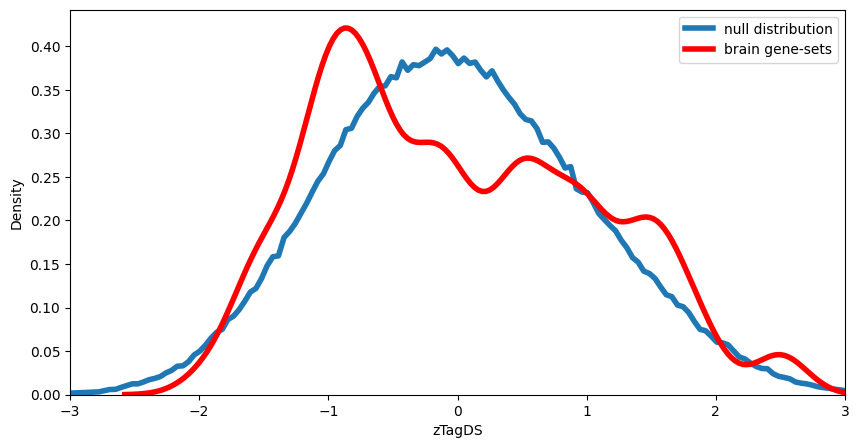

In [17]:
fig, ax = plt.subplots(1,figsize=(10,5))
sns.kdeplot(data=tmp, x='zTagDS', bw_adjust=0.2, lw=4, label='null distribution')
sns.kdeplot(data=tmp_data, x='zTagDS', c='red', bw_adjust=0.5, lw=4, label='brain gene-sets')

ax.set_xlim(-3,3)
plt.legend()
plt.show()